<IPython.core.display.Javascript object>


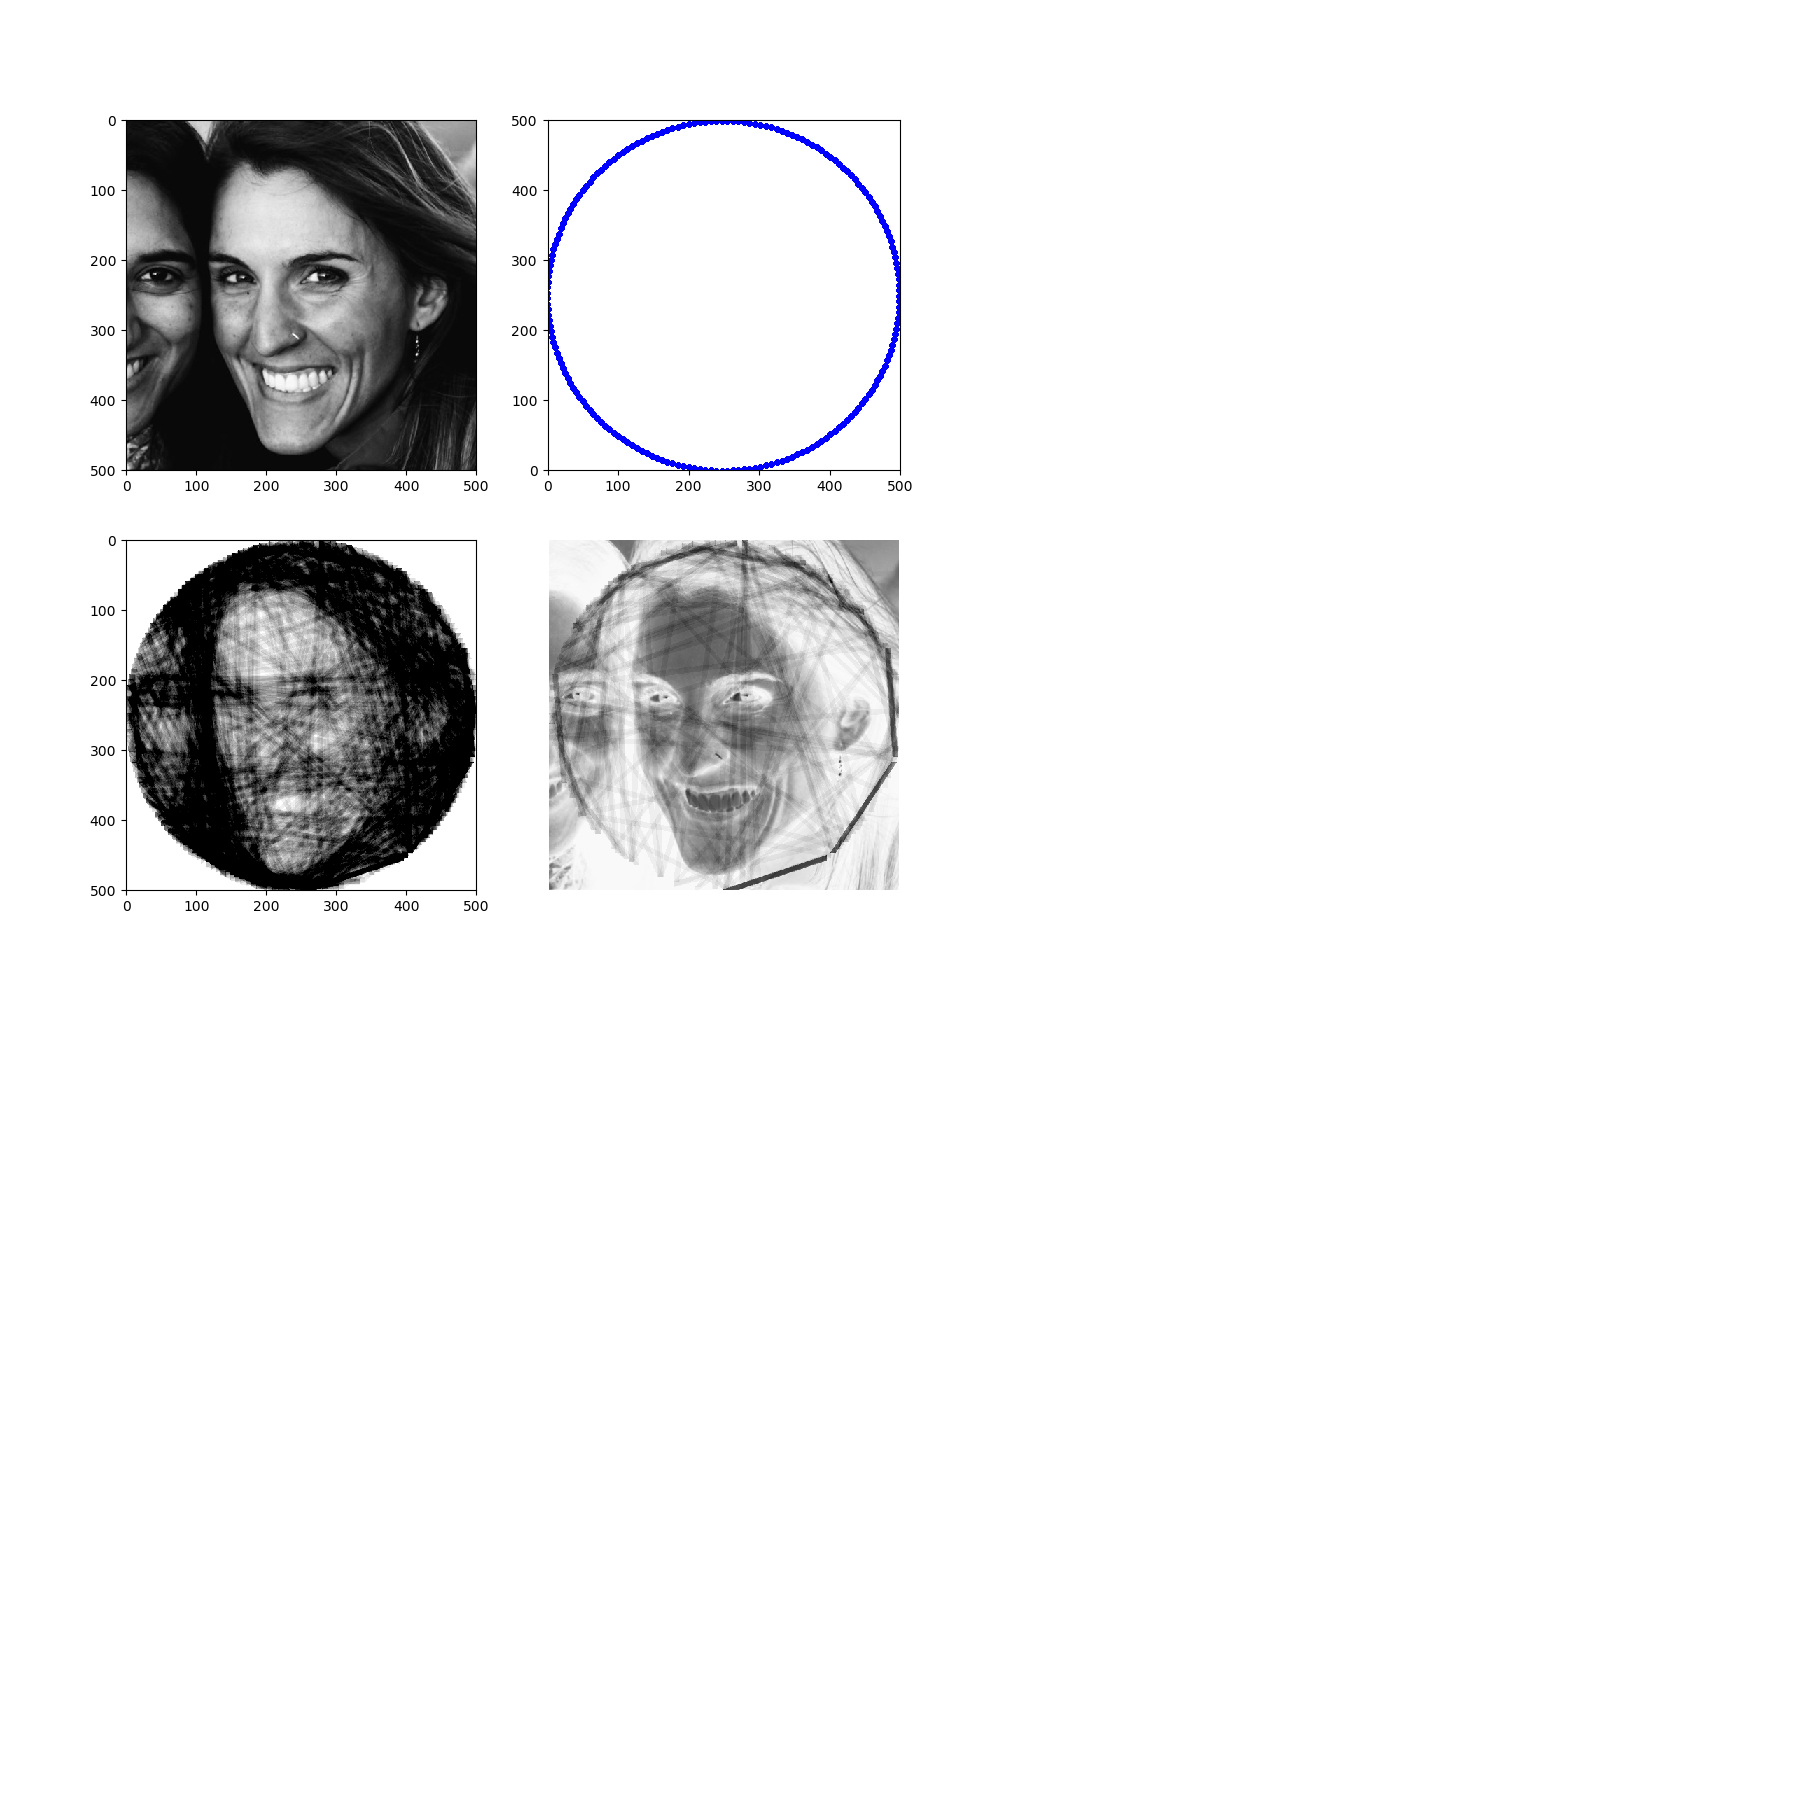

KeyboardInterrupt: 

In [1]:
import matplotlib.image as mpimg
import matplotlib
import matplotlib.pyplot as plt

import numpy as np
from bresenham import bresenham
from scipy import ndimage
from random import randint

%matplotlib nbagg

edge_size = 500
line_opacity = 15
thickness = 8
num_points = 200
padding = 20 

# Circle Points
theta = np.linspace(0, 2*np.pi, num_points)
a, b = edge_size * (np.cos(theta)+1)/2-1, edge_size * (np.sin(theta)+1)/2-1
points = zip([int(i) for i in a],[int(i) for i in b])

def get_image(f='./nerea1.jpg'):
    img = ndimage.imread(f, flatten=True)
    return img

class Plot():
    def __init__(self):
        self.fig = plt.figure(figsize=(10, 10))

        self.ax1 = self.fig.add_subplot(221)
        self.ax2 = self.fig.add_subplot(222)
        self.ax2.set_xlim([0, edge_size])
        self.ax2.set_ylim([0, edge_size])
        self.ax3 = self.fig.add_subplot(223)
        self.ax4 = self.fig.add_subplot(224)
        #self.fig.subplots(figsize=(20, 10))
        #plt.tight_layout()

    def show(self, img, raster, diff, a,b):
        self.ax1.imshow(img, cmap="gray")
        self.ax2.plot(a,b, 'b.')
        self.ax3.imshow(raster, cmap="gray")
        self.ax4.imshow(diff, cmap="gray")
        self.fig.canvas.draw()
        #plt.show()
        
        
def get_next_point(prev_i,diff):
    #i = randint(0, len(a)-1)
    best_score = -100
    starting_point =  points[prev_i]
    for i, proposed_point in enumerate(points):
        if (prev_i-i)%num_points < padding or (prev_i-i)%num_points > num_points - padding: continue        
        proposed_line = list(bresenham(starting_point[0], starting_point[1], proposed_point[0], proposed_point[1]))
        score = 0
        for point in proposed_line:
            if diff[point]<line_opacity:
                score = score + diff[point] - line_opacity
            else: 
                score = score + line_opacity
        if score/len(proposed_line)>best_score:
            best_i=i
            best_score = score / len(proposed_line)
#    print best_i
    return best_i

def draw_line(img,p1,p2):
    line_px = list(bresenham(p1[0], p1[1], p2[0], p2[1]))
    for px in line_px:
        if abs(p1[0]-p2[0])>abs(p1[1]-p2[1]):
            for j in xrange(thickness):
                if px[1]+j>=edge_size:
                    break
                img[px[0],px[1]+j] = max(img[px[0],px[1]+j] - line_opacity,0)
        else:
            for j in xrange(thickness):
                if px[0]+j>=edge_size:
                    break
                img[px[0]+j, px[1]] = max(img[px[0]+j, px[1]] - line_opacity,0)
                
    

def main():
    img = get_image()
    img = (img - img.min())/img.max()*255
    #img = img/img.max() * 255
    p = Plot()
    groundtruth = plt.imshow(img, cmap="gray")
    
    # Raster
    raster = np.zeros((edge_size, edge_size))+255
    #diff = raster - img
    diff = np.subtract(raster, img)
    i = 0
    last_point = 0
    while i<10000:
        next_point = get_next_point(last_point,diff)
        draw_line(raster,points[last_point],points[next_point])
        i = i+1
        last_point = next_point
        diff = np.subtract(raster, img)
        p.show(img,raster,diff,a,b)


if __name__ == "__main__":
    main()